In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.special import gamma, gammaln
from scipy.stats import norm
from joblib import Parallel, delayed
from tqdm import tqdm

# Import files
credit_file = "qrm25HSG_creditportfolio.xlsx"
indexes_file = "qrm25HSG_indexes.xlsx"
In_random_state = 1  # Initial random state

# Credit portfolio
credit = pd.read_excel(credit_file)  # Import from Excel using pandas
credit.columns = [
    "counterparty",
    "rating",
    "E",
    "R_k",
    "pi_k",
    "lambda_k",
    "a_k1",
    "a_k2",
]

E = credit["E"].values
R_k = credit["R_k"].values
pi_k = credit["pi_k"].values
lambda_k = credit["lambda_k"].values
a_k = credit[["a_k1", "a_k2"]].values  # a_k as vector of a_k1 and a_k2

# Indexes (SPI, SPX) – clean import structure
raw = pd.read_excel(indexes_file, header=None, skiprows=1)

# Columns: [0]=SPI date, [1]=SPI price, [2]=SPX date, [3]=SPX price
spi = raw[[0, 1]].dropna()
spi.columns = ["date", "SPI"]

spx = raw[[2, 3]].dropna()
spx.columns = ["date", "SPX"]

# Convert dates
spi["date"] = pd.to_datetime(spi["date"], errors="coerce")
spx["date"] = pd.to_datetime(spx["date"], errors="coerce")

# Remove invalid rows
spi = spi.dropna().reset_index(drop=True)
spx = spx.dropna().reset_index(drop=True)

# Sort chronologically
spi = spi.sort_values("date").reset_index(drop=True)
spx = spx.sort_values("date").reset_index(drop=True)

# Merge on date
indexes = pd.merge(spi, spx, on="date", how="inner")

# Daily log-returns
indexes["r_SPI"] = np.log(indexes["SPI"] / indexes["SPI"].shift(1))
indexes["r_SPX"] = np.log(indexes["SPX"] / indexes["SPX"].shift(1))

indexes = indexes.dropna().reset_index(drop=True)
Theta_daily = indexes[["r_SPI", "r_SPX"]].values

print("Import completed without errors.")
print("Shape of credit dataset:", credit.shape)
print("Shape of daily returns:", Theta_daily.shape)
print(indexes.head())

Import completed without errors.
Shape of credit dataset: (100, 8)
Shape of daily returns: (5091, 2)
        date         SPI         SPX     r_SPI     r_SPX
0 2005-01-04 4294.560000 1188.185100  0.001258 -0.011631
1 2005-01-05 4259.730000 1183.984500 -0.008143 -0.003542
2 2005-01-06 4271.480000 1188.403000  0.002755  0.003725
3 2005-01-07 4266.760000 1186.709600 -0.001106 -0.001426
4 2005-01-10 4265.260000 1190.776700 -0.000352  0.003421


In [46]:
# Weekly log-returns (SPI, SPX)
indexes = indexes.sort_values("date").reset_index(drop=True)

# Weekly resample 
weekly = indexes.set_index("date").resample("W").last()

# Compute weekly log-returns
weekly["rw_SPI"] = np.log(weekly["SPI"] / weekly["SPI"].shift(1))
weekly["rw_SPX"] = np.log(weekly["SPX"] / weekly["SPX"].shift(1))

# Remove first row because we have data and tickers
weekly = weekly.dropna().reset_index()

# Theta vector of log- weekly returns
Theta = weekly[["rw_SPI", "rw_SPX"]].values

# Final DataFrame of factors (for models M1, M2, M3)
Theta_df = weekly[["date", "rw_SPI", "rw_SPX"]].copy()

print("Weekly log-return computation completed.")
print("Theta shape (weekly returns):", Theta.shape)
print(Theta_df.head())

print(np.mean(Theta))
rho_empirical = np.corrcoef(Theta, rowvar=False)[0, 1]
print("Rho Empirical: ", rho_empirical)

Weekly log-return computation completed.
Theta shape (weekly returns): (1083, 2)
        date   rw_SPI    rw_SPX
0 2005-01-16 0.000183 -0.001210
1 2005-01-23 0.002427 -0.014053
2 2005-01-30 0.002482  0.003181
3 2005-02-06 0.017223  0.027118
4 2005-02-13 0.013224  0.002634
0.001636775242186835
Rho Empirical:  0.7297155966270944


M1 simulations (5 draws):
[[-0.00177911  0.00770097]
 [-0.00113876  0.00942494]
 [ 0.02484227 -0.02521567]
 [-0.01791564  0.0025499 ]
 [ 0.01715249  0.01130607]]


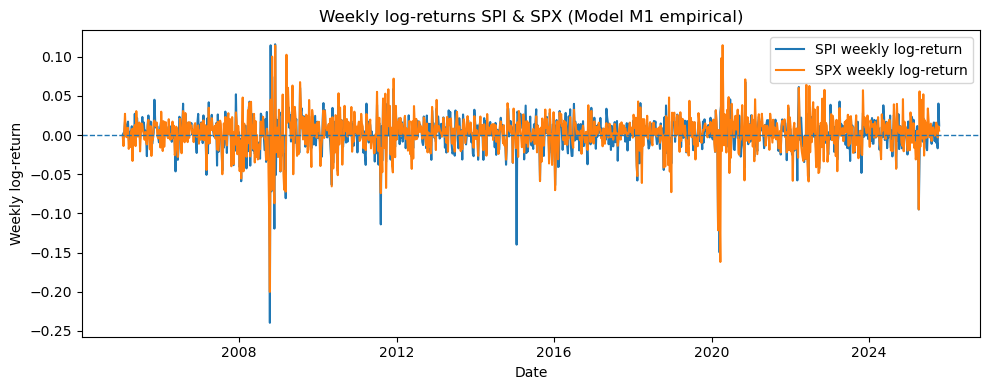

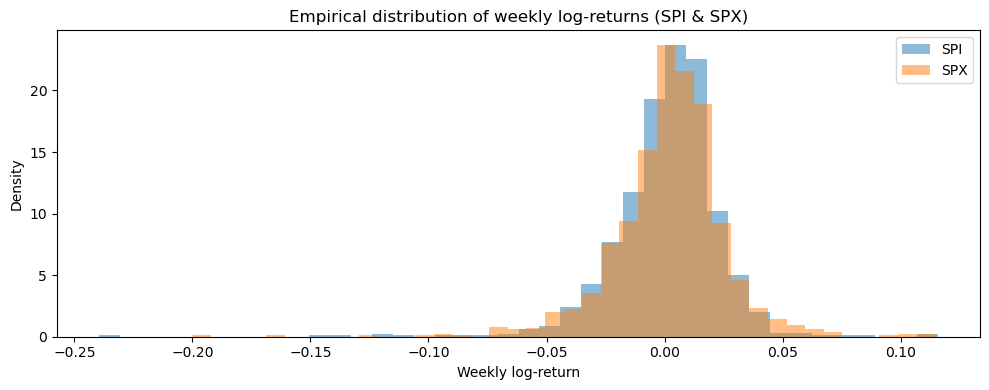

In [47]:
# Empirical weekly returns (Theta)
Theta_empirical = Theta.copy()  # shape (T_weekly, 2)

def sim_M1(N, random_state=None): # Simulates N realizations of Θ under Model M1 by resampling from the empirical distribution.
    
    rng = np.random.default_rng(random_state)

    # number of historical weekly observations
    T = Theta_empirical.shape[0]

    # draw random indices with replacement
    idx = rng.integers(0, T, size=N)

    # select corresponding rows of empirical factors
    Theta_sim = Theta_empirical[idx, :]

    return Theta_sim

# test
Theta_test = sim_M1(5, random_state=In_random_state)
print("M1 simulations (5 draws):")
print(Theta_test)

# Plot: weekly historical returns series
plt.figure(figsize=(10, 4))
plt.plot(Theta_df["date"], Theta_df["rw_SPI"], label="SPI weekly log-return")
plt.plot(Theta_df["date"], Theta_df["rw_SPX"], label="SPX weekly log-return")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Weekly log-return")
plt.title("Weekly log-returns SPI & SPX (Model M1 empirical)")
plt.legend()
plt.tight_layout()

# Plot: empirical distribution of weekly returns
plt.figure(figsize=(10, 4))
plt.hist(Theta_df["rw_SPI"], bins=40, density=True, alpha=0.5, label="SPI")
plt.hist(Theta_df["rw_SPX"], bins=40, density=True, alpha=0.5, label="SPX")
plt.xlabel("Weekly log-return")
plt.ylabel("Density")
plt.title("Empirical distribution of weekly log-returns (SPI & SPX)")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# Defining functions for M2 Model - Bivariate Gaussian

def fit_M2(Theta): # This function Fit μ and Σ of Model M2 via maximum likelihood.
    
    Theta = np.asarray(Theta)
    n, d = Theta.shape  # n = observations, d = dimension, 2 in this case

    mu_M2 = Theta.mean(axis=0) # Sample mean (MLE for Gaussian)

    # Sample covariance with denominator n
    Xc = Theta - mu_M2
    Sigma_M2 = (Xc.T @ Xc) / n # Σ^ Formula in the paper, 

    return mu_M2, Sigma_M2


def sim_M2(N, mu_M2, Sigma_M2, random_state=None): # This function Simulate N realizations of Θ from Model M2: N(μ, Σ).

    rng = np.random.default_rng(random_state) # Utility defined for the function

    A = np.linalg.cholesky(Sigma_M2) # Cholesky factor of Σ (Σ = A Aᵀ)

    Z = rng.standard_normal(size=(N, 2)) # Draw standard Gaussian shocks Z ~ N(0, I)

    Theta_sim = mu_M2 + Z @ A.T # Building simulated Theta vector: Θ = μ + A Z

    return Theta_sim


# Fit Model M2 on weekly data
mu_M2, Sigma_M2 = fit_M2(Theta)

print("μ_M2 (mean vector):", mu_M2)
print("Σ_M2 (covariance matrix):")
print(Sigma_M2)

# Quick simulation test
Theta_M2_test = sim_M2(5, mu_M2, Sigma_M2, random_state=In_random_state)

rho_M2 = Sigma_M2[0,1] / np.sqrt(Sigma_M2[0,0] * Sigma_M2[1,1])
print("Rho M2:", rho_M2)

print("\nTheta simulations from M2 (5 draws):")
print(Theta_M2_test)

μ_M2 (mean vector): [0.00129894 0.00197461]
Σ_M2 (covariance matrix):
[[0.00052606 0.00040879]
 [0.00040879 0.00059657]]
Rho M2: 0.7297155966270945

Theta simulations from M2 (5 draws):
[[ 0.00922527  0.02185541]
 [ 0.00887786 -0.01389929]
 [ 0.02206422  0.02556556]
 [-0.01101665  0.00210936]
 [ 0.00966079  0.01338459]]


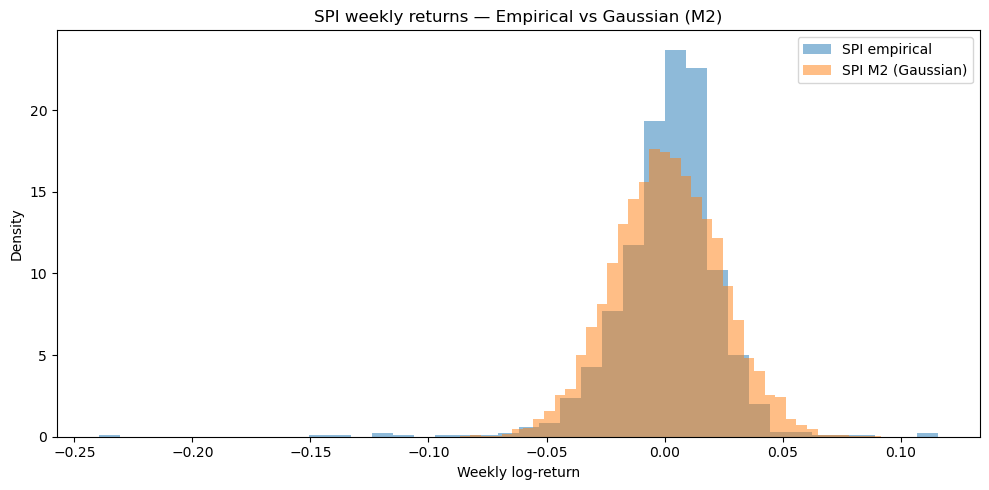

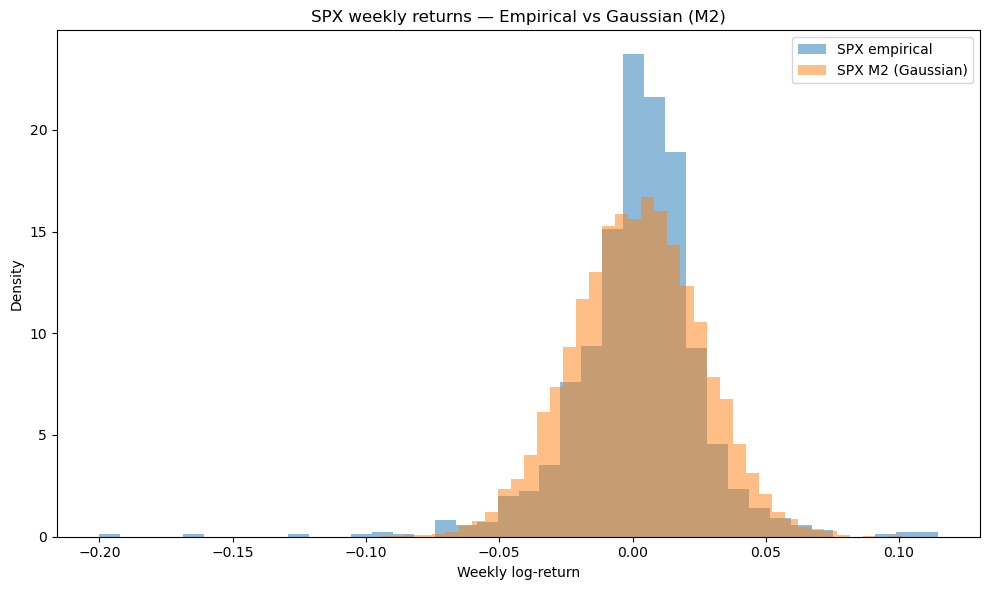

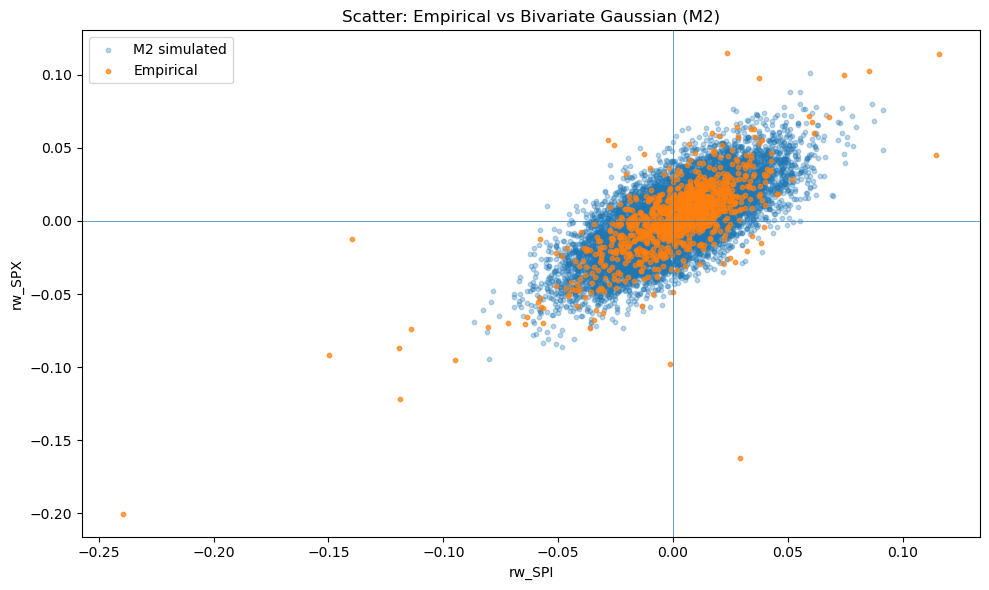

In [49]:
# Plots for M2 — empirical vs Gaussian comparison

# Simulate a large number of points from M2
Theta_M2_sim = sim_M2(10000, mu_M2, Sigma_M2, random_state=In_random_state)
SPI_sim = Theta_M2_sim[:, 0]
SPX_sim = Theta_M2_sim[:, 1]

# SPI – empirical vs M2 (Gaussian)
plt.figure(figsize=(10,5))

plt.hist(Theta_df["rw_SPI"],bins=40,density=True,alpha=0.5,label="SPI empirical",color="C0")
plt.hist(SPI_sim,bins=40,density=True,alpha=0.5,label="SPI M2 (Gaussian)",color="C1")
plt.xlabel("Weekly log-return")
plt.ylabel("Density")
plt.title("SPI weekly returns — Empirical vs Gaussian (M2)")
plt.legend()
plt.tight_layout()

# SPX – empirical vs M2 (Gaussian)
plt.figure(figsize=(10, 6))
plt.hist(Theta_df["rw_SPX"],bins=40,density=True,alpha=0.5,label="SPX empirical",color="C0")
plt.hist(SPX_sim,bins=40,density=True,alpha=0.5,label="SPX M2 (Gaussian)",color="C1")
plt.xlabel("Weekly log-return")
plt.ylabel("Density")
plt.title("SPX weekly returns — Empirical vs Gaussian (M2)")
plt.legend()
plt.tight_layout()

# Scatter plot: empirical vs M2
plt.figure(figsize=(10,6))

# Simulated M2 (blue points)
plt.scatter(SPI_sim,SPX_sim,alpha=0.3,s=10,label="M2 simulated",color="C0")

# Empirical (orange points)
plt.scatter(Theta_df["rw_SPI"],Theta_df["rw_SPX"],alpha=0.7,s=10,label="Empirical",color="C1")

plt.xlabel("rw_SPI")
plt.ylabel("rw_SPX")
plt.title("Scatter: Empirical vs Bivariate Gaussian (M2)")
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
# Model M3 — Gaussian marginals + t-copula(ρ, ν)

def fit_marginals_normal(Theta):
    # Sample mean (MLE for Gaussian)
    mu = Theta.mean(axis=0)

    # Sample std (MLE uses ddof=0 → divide by N)
    sigma = Theta.std(axis=0, ddof=0)

    return mu, sigma


def log_t_copula_density(u, rho, nu):
    # Convert uniforms to t-quantiles
    x1 = stats.t.ppf(u1, df=nu)
    x2 = stats.t.ppf(u2, df=nu)

    # Univariate t-densities as in the main paper
    c1 = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma(nu / 2))
    ft1_x1 = c1 * (1 + x1**2 / nu) ** (-(nu + 1) / 2)
    ft1_x2 = c1 * (1 + x2**2 / nu) ** (-(nu + 1) / 2)

    # Bivariate t-density as in the main paper
    rho2 = rho ** 2
    denom = nu * (1 - rho2)
    quad = (x1**2 - 2 * rho * x1 * x2 + x2**2) / denom
    c2 = gamma((nu + 2) / 2) / (gamma(nu / 2) * np.pi * nu * np.sqrt(1 - rho2))
    ft2 = c2 * (1 + quad) ** (-(nu + 2) / 2)

    # log copula density
    log_c = np.log(ft2) - np.log(ft1_x1) - np.log(ft1_x2)
    return log_c


def fit_t_copula(U):
    # Clip uniforms to avoid exactly 0 or 1
    eps_u = 1e-6
    U_raw = U.copy()
    U_clipped = np.clip(U_raw, eps_u, 1 - eps_u)

    # count number of clipped components
    n_clipped = np.sum(U_raw != U_clipped)

    # updated uniforms
    U = U_clipped
    u1 = U[:, 0]
    u2 = U[:, 1]

    # log-likelihood of t-copula
    def neg_loglik(params):
        a, b = params

        # ρ is mapped through tanh, ensures |ρ| < 1
        rho = np.tanh(a) # Already good for ρ=[0,1]
        rho = np.clip(rho, -0.999, 0.999) # Ensuring no numerical problems
        rho2 = rho * rho

        # ν = 1 + exp(b) ensures ν > 1
        nu = 1 + np.exp(b)
        nu = np.clip(nu, 1, 40)

        # Convert to t-quantiles
        x1 = stats.t.ppf(u1, df=nu)
        x2 = stats.t.ppf(u2, df=nu)

        # Marginal t densities
        ft1_x1 = stats.t.pdf(x1, df=nu)
        ft1_x2 = stats.t.pdf(x2, df=nu)

        ft1_x1 = np.clip(ft1_x1, 1e-7, None)
        ft1_x2 = np.clip(ft1_x2, 1e-7, None)

        # Bivariate t log-density
        denom = nu * (1 - rho2)
        denom = np.clip(denom, 1e-6, None)

        quad = (x1**2 - 2 * rho * x1 * x2 + x2**2) / denom
        quad = np.clip(quad, -1e6, 1e6)

        log_ft2 = ( # bivariate t distribution
            gammaln((nu + 2) / 2)
            - gammaln(nu / 2)
            - np.log(np.pi * nu * np.sqrt(1 - rho2))
            - (nu + 2) / 2 * np.log1p(quad)
        )

        # subtract marginal logs gives log copula density
        log_ft1 = np.log(ft1_x1) + np.log(ft1_x2)
        log_c = log_ft2 - log_ft1

        if not np.all(np.isfinite(log_c)):
            return 1e12

        return -np.sum(log_c)

    # initial guess for ρ from Gaussian copula
    z_init = stats.norm.ppf(U)
    rho0 = np.corrcoef(z_init.T)[0, 1]
    rho0 = np.clip(rho0, -0.999, 0.999)
    a0 = np.arctanh(rho0)

    # initial guess for ν ex: b=0 gives ν=2
    b0 = np.log(1)
    x0 = np.array([a0, b0])

    # optimization
    res = minimize(
        neg_loglik,
        x0,
        method="L-BFGS-B", # Good for models with boundaries on parameters
        bounds=[(-5, 5), (np.log(0.1), np.log(50))]
    )

    # extract parameters
    if not res.success:
        rho_hat = rho0
        nu_hat = 10.0
    else:
        a_hat, b_hat = res.x
        rho_hat = np.tanh(a_hat)
        rho_hat = np.clip(rho_hat, -0.999, 0.999)
        nu_hat = 1 + np.exp(b_hat)
        nu_hat = np.clip(nu_hat, 0.05, 40)

    return rho_hat, nu_hat, res


def fit_M3(Theta):
    # Gaussian marginal fits
    mu_M3, sigma_M3 = fit_marginals_normal(Theta)

    # Convert Θ → standard normals → uniforms
    Z = (Theta - mu_M3) / sigma_M3
    U = stats.norm.cdf(Z)

    # Fit t-copula dependence
    rho_M3, nu_M3, opt_res = fit_t_copula(U)

    return mu_M3, sigma_M3, rho_M3, nu_M3, opt_res


# Fit M3 on weekly data
mu_M3, sigma_M3, rho_M3, nu_M3, opt_res_M3 = fit_M3(Theta)

print("μ_M3:", mu_M3)
print("σ_M3:", sigma_M3)
print("ρ_M3:", rho_M3)
print("ν_M3:", nu_M3)
print("Optimization success:", opt_res_M3.success)


def sim_M3(N, mu_M3, sigma_M3, rho_M3, nu_M3, random_state=None):
    # Random generator
    rng = np.random.default_rng(random_state)

    # Gaussian correlation matrix
    Sigma = np.array([[1.0, rho_M3],
                      [rho_M3, 1.0]])

    # Gaussian sample Z ~ N(0, Σ)
    A = np.linalg.cholesky(Sigma)
    Z = rng.standard_normal(size=(N, 2)) @ A.T

    # chi-square shocks for Student-t
    W = rng.chisquare(df=nu_M3, size=N)

    # bivariate t sample
    X = np.sqrt(nu_M3 / W)[:, None] * Z

    # convert to uniforms via t-CDF
    U = stats.t.cdf(X, df=nu_M3)

    # Gaussian margins
    G = stats.norm.ppf(U)

    # final Θ = μ + σ * G
    Theta_sim = mu_M3 + sigma_M3 * G

    return Theta_sim

μ_M3: [0.00129894 0.00197461]
σ_M3: [0.02293604 0.02442478]
ρ_M3: 0.786820205849994
ν_M3: 5.31576171282077
Optimization success: True


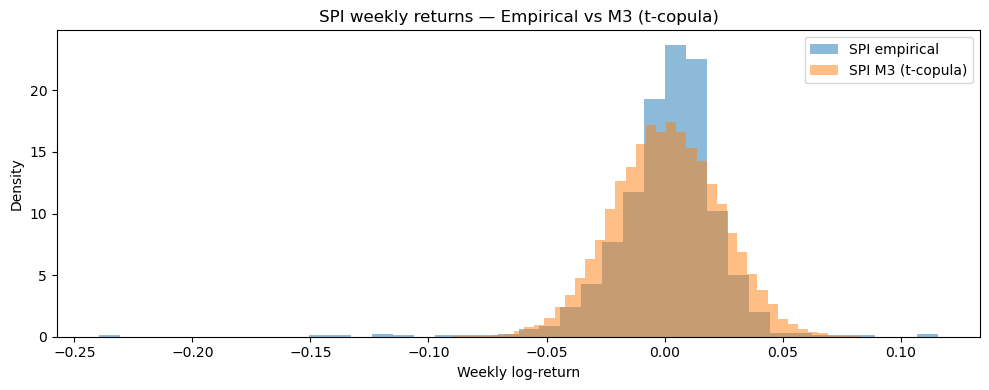

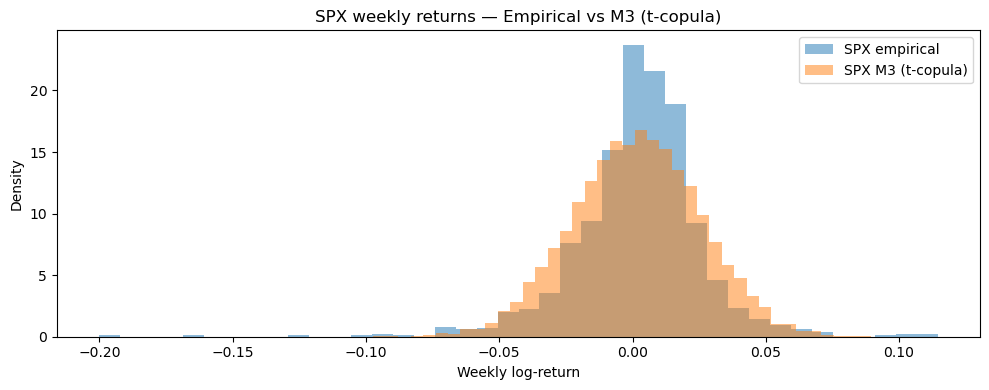

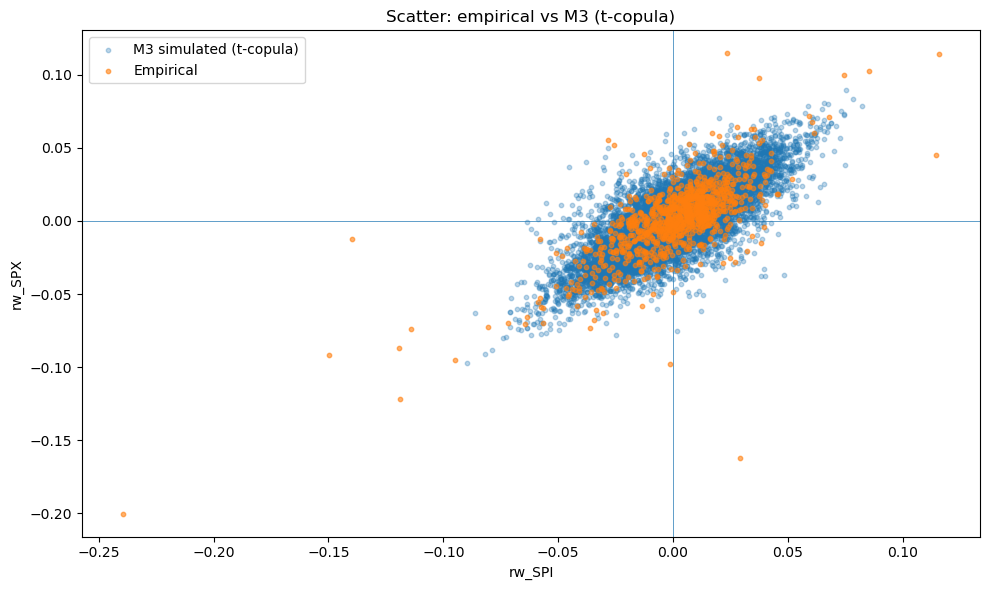

In [51]:
# Simulate from M3 (t-copula model)
Theta_M3_sim = sim_M3(10000, mu_M3, sigma_M3, rho_M3, nu_M3, random_state=In_random_state)
SPI_sim_M3 = Theta_M3_sim[:, 0]
SPX_sim_M3 = Theta_M3_sim[:, 1]

# Plot: SPI – empirical vs M3 (t-copula)
plt.figure(figsize=(10, 4))
plt.hist(Theta_df["rw_SPI"], bins=40, density=True, alpha=0.5, label="SPI empirical")
plt.hist(SPI_sim_M3, bins=40, density=True, alpha=0.5, label="SPI M3 (t-copula)")
plt.xlabel("Weekly log-return")
plt.ylabel("Density")
plt.title("SPI weekly returns — Empirical vs M3 (t-copula)")
plt.legend()
plt.tight_layout()

# Plot: SPX – empirical vs M3 (t-copula)
plt.figure(figsize=(10, 4))
plt.hist(Theta_df["rw_SPX"], bins=40, density=True, alpha=0.5, label="SPX empirical")
plt.hist(SPX_sim_M3, bins=40, density=True, alpha=0.5, label="SPX M3 (t-copula)")
plt.xlabel("Weekly log-return")
plt.ylabel("Density")
plt.title("SPX weekly returns — Empirical vs M3 (t-copula)")
plt.legend()
plt.tight_layout()

# Scatter: empirical vs M3 (t-copula)
plt.figure(figsize=(10, 6))

# Background: M3 t-copula simulations
plt.scatter(SPI_sim_M3, SPX_sim_M3, alpha=0.3, s=10, label="M3 simulated (t-copula)", zorder=1)

# Overlay: empirical data
plt.scatter(Theta_df["rw_SPI"], Theta_df["rw_SPX"], alpha=0.6, s=10, label="Empirical", zorder=2)

plt.xlabel("rw_SPI")
plt.ylabel("rw_SPX")
plt.title("Scatter: empirical vs M3 (t-copula)")
plt.axhline(0, linewidth=0.5, zorder=0)
plt.axvline(0, linewidth=0.5, zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Joint extreme negative returns under the quantile

q_spi = np.quantile(Theta[:, 0], 0.01) # 0.01 quantile
q_spx = np.quantile(Theta[:, 1], 0.01)

def joint_tail_prob(sample):
    spi = sample[:, 0]
    spx = sample[:, 1]
    return np.mean((spi < q_spi) & (spx < q_spx))

p_emp  = joint_tail_prob(Theta)          # data
p_M2   = joint_tail_prob(Theta_M2_sim)   # sim M2
p_M3   = joint_tail_prob(Theta_M3_sim)   # sim M3


print("p_emp: ", p_emp)
print("p_M2: ", p_M2)
print("p_M3: ", p_M3)

p_emp:  0.007386888273314866
p_M2:  0.0003
p_M3:  0.0013


In [53]:
# Compute s_k empirically (correct for M1)
A = a_k
K = A.shape[0]                    # define number of counterparties
proj = Theta_empirical @ A.T      # projection of factors onto factor loadings
s_k = proj.std(axis=0, ddof=0)    # empirical standard deviation of projections

print("First 5 s_k:", s_k[:5])


# Simulate Y_k under M1 (10,000 simulations)
N_sim = 10_000
Theta_sim_M1 = sim_M1(N_sim, random_state=In_random_state)

# Systematic part: sqrt(lambda_k) * a_k' Θ
systematic_part = (Theta_sim_M1 @ A.T) * np.sqrt(lambda_k)[None, :]

# Idiosyncratic part: sqrt(1 - lambda_k) * s_k * ε_k
eps = np.random.randn(N_sim, K)
idiosyncratic_part = np.sqrt(1 - lambda_k)[None, :] * s_k[None, :] * eps

# Latent variables Y_k
Y_M1 = systematic_part + idiosyncratic_part
print("Shape Y_M1:", Y_M1.shape)


# Compute d_k empirically (correct for M1)
d_k_M1 = np.zeros(K)
for k in range(K):
    d_k_M1[k] = np.quantile(Y_M1[:, k], pi_k[k])


# Default indicators and simulated PDs
I_M1 = (Y_M1 <= d_k_M1[None, :]).astype(int)
PD_sim_M1 = I_M1.mean(axis=0)

check = pd.DataFrame({
    "pi_k": pi_k,
    "PD_sim_M1": PD_sim_M1
})

pd.options.display.float_format = '{:.6f}'.format
print(check.head())

First 5 s_k: [0.0182185  0.02825903 0.03113567 0.02224819 0.02622715]
Shape Y_M1: (10000, 100)
      pi_k  PD_sim_M1
0 0.000200   0.000200
1 0.000200   0.000200
2 0.000200   0.000200
3 0.000200   0.000200
4 0.000200   0.000200


In [54]:
# Simulate Θ under M2
N_sim = 10_000
Theta_sim_M2 = sim_M2(N_sim, mu_M2, Sigma_M2, random_state=In_random_state)

# Systematic part under M2: sqrt(lambda_k) * (a_k' Θ_i)
systematic_part_M2 = (Theta_sim_M2 @ A.T) * np.sqrt(lambda_k)[None, :]

# Idiosyncratic part under M2 (same structure as M1)
eps_M2 = np.random.randn(N_sim, K)
idiosyncratic_part_M2 = np.sqrt(1 - lambda_k)[None, :] * s_k[None, :] * eps_M2

# Latent variables Y_k under M2
Y_M2 = systematic_part_M2 + idiosyncratic_part_M2
print("Shape Y_M2:", Y_M2.shape)

# Compute d_k_M2 such that P(Y_k ≤ d_k) = pi_k
d_k_M2 = np.zeros(K)
for k in range(K):
    d_k_M2[k] = np.quantile(Y_M2[:, k], pi_k[k])

print("First 5 d_k_M2:", d_k_M2[:5])

Shape Y_M2: (10000, 100)
First 5 d_k_M2: [-0.05794196 -0.1000952  -0.10333328 -0.07585641 -0.0873805 ]


In [55]:
# Simulate Θ under M3 (10,000 simulations)
N_sim = 10_000
Theta_sim_M3 = sim_M3(N_sim, mu_M3, sigma_M3, rho_M3, nu_M3, random_state=In_random_state)
# shape (10000, 2)

# Systematic part under M3: sqrt(lambda_k) * (a_k' Θ_i)
systematic_part_M3 = (Theta_sim_M3 @ A.T) * np.sqrt(lambda_k)[None, :]
# shape (10000, 100)

# Idiosyncratic part under M3 (same structure as M1 and M2)
eps_M3 = np.random.randn(N_sim, A.shape[0])   # (10000 × 100)
idiosyncratic_part_M3 = np.sqrt(1 - lambda_k)[None, :] * s_k[None, :] * eps_M3
# shape (10000, 100)

# Latent variables Y_k under M3
Y_M3 = systematic_part_M3 + idiosyncratic_part_M3
# shape (10000, 100)

print("Shape Y_M3:", Y_M3.shape)

# Compute d_k_M3 such that P(Y_M3 <= d_k) = pi_k
d_k_M3 = np.zeros(K)
for k in range(K):
    d_k_M3[k] = np.quantile(Y_M3[:, k], pi_k[k])

print("First 5 d_k_M3:", d_k_M3[:5])

print("Rho M3:", rho_M3)
print("Nu M3:", nu_M3)

Shape Y_M3: (10000, 100)
First 5 d_k_M3: [-0.06742798 -0.09740231 -0.11025957 -0.07659941 -0.08539331]
Rho M3: 0.786820205849994
Nu M3: 5.31576171282077


In [56]:
# Portfolio loss distribution for M1, M2, M3

# LGD for each counterparty: E_k * (1 - R_k)
LGD = E * (1.0 - R_k)
K = LGD.shape[0]

# use same number of simulations as in M1
N_sim = Y_M1.shape[0]

# Default indicators: I_k = 1 if Y_k ≤ d_k
I_M1 = (Y_M1 <= d_k_M1[None, :]).astype(int)
I_M2 = (Y_M2 <= d_k_M2[None, :]).astype(int)
I_M3 = (Y_M3 <= d_k_M3[None, :]).astype(int)

# Portfolio losses: L[i] = Σ_k I_k(i) · LGD_k
L_M1 = (I_M1 * LGD[None, :]).sum(axis=1)
L_M2 = (I_M2 * LGD[None, :]).sum(axis=1)
L_M3 = (I_M3 * LGD[None, :]).sum(axis=1)

print("Loss M1:", L_M1.shape, "example:", L_M1[:5])
print("Loss M2:", L_M2.shape, "example:", L_M2[:5])
print("Loss M3:", L_M3.shape, "example:", L_M3[:5])

Loss M1: (10000,) example: [ 23255.39614236   3984.04143927  37017.33759991 103476.77131646
  42858.75610826]
Loss M2: (10000,) example: [    0.         26713.71354627 19926.54637968 20919.85496726
 49331.93255843]
Loss M3: (10000,) example: [    0.          6319.58261437 30822.38398405 84816.07596826
     0.        ]


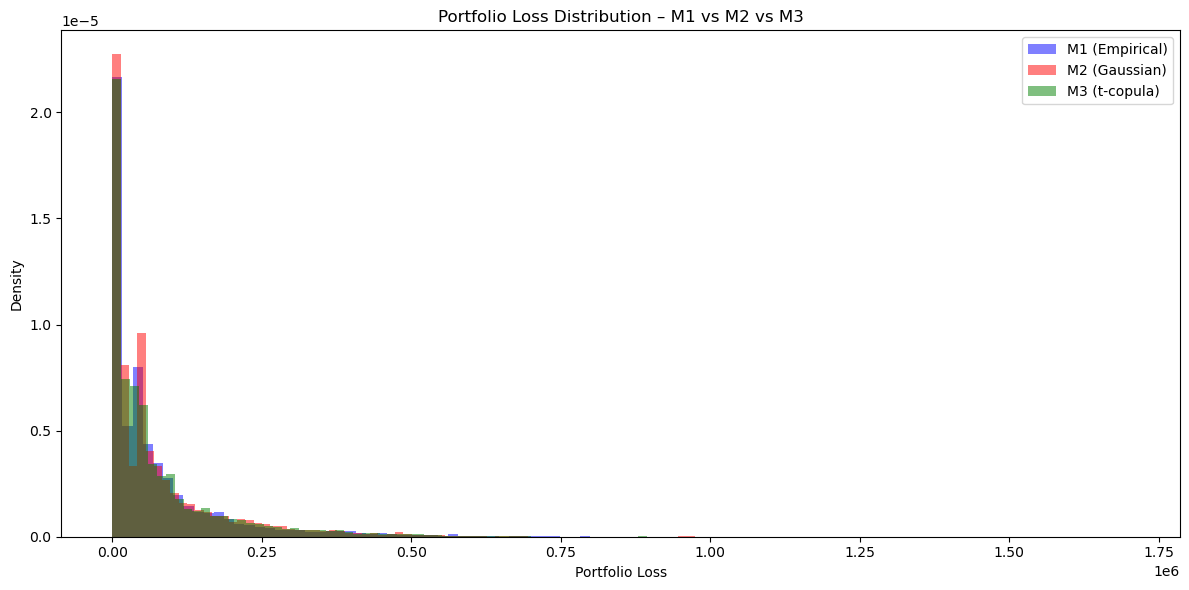

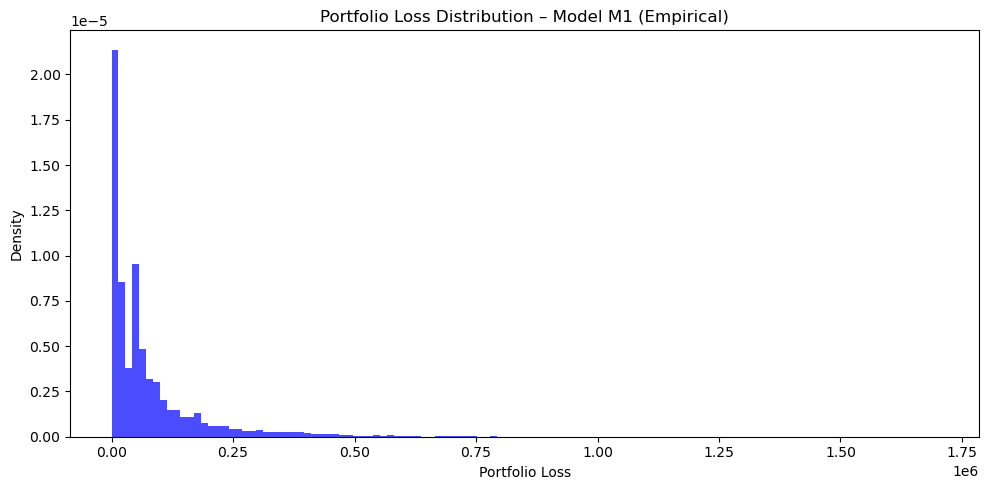

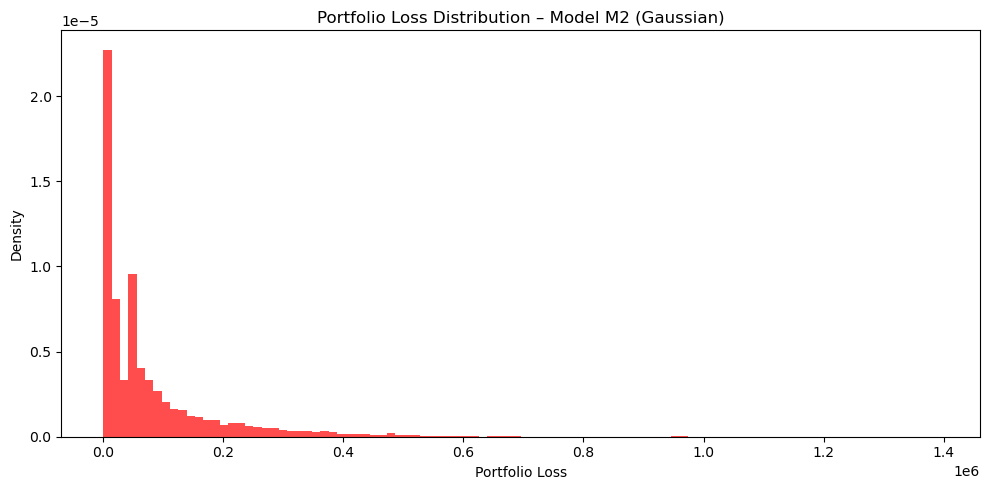

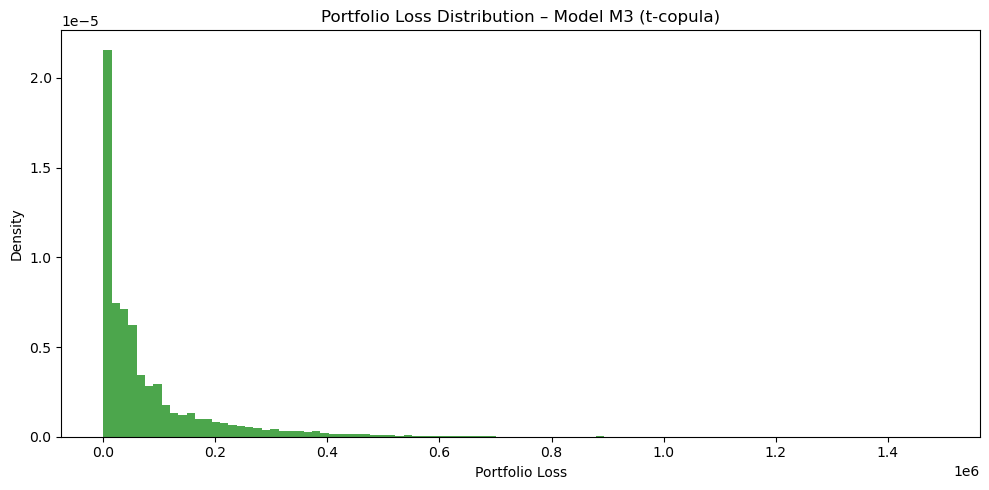

In [57]:
# Plot: all three models together
plt.figure(figsize=(12, 6))
plt.hist(L_M1, bins=100, alpha=0.5, density=True, label="M1 (Empirical)", color="blue")
plt.hist(L_M2, bins=100, alpha=0.5, density=True, label="M2 (Gaussian)", color="red")
plt.hist(L_M3, bins=100, alpha=0.5, density=True, label="M3 (t-copula)", color="green")
plt.xlabel("Portfolio Loss")
plt.ylabel("Density")
plt.title("Portfolio Loss Distribution – M1 vs M2 vs M3")
plt.legend()
plt.tight_layout()
plt.show()

# Plot: only M1
plt.figure(figsize=(10, 5))
plt.hist(L_M1, bins=120, density=True, alpha=0.7, color="blue")
plt.xlabel("Portfolio Loss")
plt.ylabel("Density")
plt.title("Portfolio Loss Distribution – Model M1 (Empirical)")
plt.tight_layout()
plt.show()

# Plot: only M2
plt.figure(figsize=(10, 5))
plt.hist(L_M2, bins=100, density=True, alpha=0.7, color="red")
plt.xlabel("Portfolio Loss")
plt.ylabel("Density")
plt.title("Portfolio Loss Distribution – Model M2 (Gaussian)")
plt.tight_layout()
plt.show()

# Plot: only M3
plt.figure(figsize=(10, 5))
plt.hist(L_M3, bins=100, density=True, alpha=0.7, color="green")
plt.xlabel("Portfolio Loss")
plt.ylabel("Density")
plt.title("Portfolio Loss Distribution – Model M3 (t-copula)")
plt.tight_layout()
plt.show()

In [ ]:
def describe_losses(L): # Computing stats for each Loss distribution as described in the paper 
    return pd.Series({
        "Mean": L.mean(),
        "Std": L.std(),
        "Skewness": pd.Series(L).skew(),
        "Kurtosis": pd.Series(L).kurt(),
        "Max": L.max(),
        "P(L=0)": np.mean(L == 0)
    })

describe_losses(L_M1), describe_losses(L_M2), describe_losses(L_M3)



(Mean         76963.911600
 Std         118148.348952
 Skewness         3.956152
 Kurtosis        28.456970
 Max        1700407.177102
 P(L=0)           0.243000
 dtype: float64,
 Mean         76963.911600
 Std         107923.484888
 Skewness         2.548833
 Kurtosis         9.773022
 Max        1390891.449482
 P(L=0)           0.261600
 dtype: float64,
 Mean         76963.911600
 Std         109767.636886
 Skewness         2.713763
 Kurtosis        11.974677
 Max        1490010.118689
 P(L=0)           0.270700
 dtype: float64)

In [94]:
# VALUE-AT-RISK (VaR) and EXPECTED SHORTFALL (ES) for M1, M2, M3

alpha = 0.99 

def compute_var_es(L, alpha=0.99):
    VaR = np.quantile(L, alpha)
    ES = L[L >= VaR].mean()
    return VaR, ES


VaR_M1, ES_M1 = compute_var_es(L_M1, alpha)
VaR_M2, ES_M2 = compute_var_es(L_M2, alpha)
VaR_M3, ES_M3 = compute_var_es(L_M3, alpha)

print(f"=== {round(alpha*100)}% VaR & ES ===\n")
print(f"M1 (Empirical Θ): VaR = {VaR_M1:,.2f} ES = {ES_M1:,.2f}")
print(f"M2 (Gaussian Θ): VaR = {VaR_M2:,.2f} ES = {ES_M2:,.2f}")
print(f"M3 (t-copula Θ): VaR = {VaR_M3:,.2f} ES = {ES_M3:,.2f}")

=== 99% VaR & ES ===

M1 (Empirical Θ): VaR = 548,270.72 ES = 742,421.57
M2 (Gaussian Θ): VaR = 486,743.38 ES = 590,656.53
M3 (t-copula Θ): VaR = 498,010.62 ES = 612,306.10


In [ ]:
# Number and frequency of joint crashes

# Weekly returns (Theta)
spi = Theta_empirical[:, 0]
spx = Theta_empirical[:, 1]

# Crash thresholds
thr_spi = np.quantile(spi, 0.05)   # bottom 5% SPI
thr_spx = np.quantile(spx, 0.05)   # bottom 5% SPX

# Crash indicators
crash_spi = spi < thr_spi
crash_spx = spx < thr_spx

# Joint crashes
joint_crashes = np.sum(crash_spi & crash_spx)
total_obs = len(spi)


print("Number of Joint crashes: ",joint_crashes)
print("Crash frequency: ", joint_crashes / total_obs) # Crashes on total

Number of Joint crashes:  34
Crash frequency:  0.03139427516158818


In [ ]:
# Rolling window parameters for dynamic VaR & ES
## We use parallelization to speed up the execution of the script by distributing the computations across multiple CPU cores

window = 500       # rolling window length (daily)
alpha = 0.95       # confidence level
N_sim = 10000      # Monte Carlo simulations per window

# Build daily log-returns from prices (if not already present)
if "r_SPI" not in indexes.columns or "r_SPX" not in indexes.columns:
    indexes = indexes.sort_values("date")
    indexes["r_SPI"] = np.log(indexes["SPI"] / indexes["SPI"].shift(1))
    indexes["r_SPX"] = np.log(indexes["SPX"] / indexes["SPX"].shift(1))

# Remove initial NaNs
indexes = indexes.dropna(subset=["r_SPI", "r_SPX", "SPI", "SPX"]).reset_index(drop=True)

# Daily dataframe with dates, prices and returns
r_daily = indexes[["date", "SPI", "SPX", "r_SPI", "r_SPX"]].copy()
T_daily = len(r_daily)


def process_window(t):
    """
    Process a single rolling window and return VaR/ES for M1, M2, M3 plus date.
    """
    # 1. Extract rolling daily window [t-window, t)
    window_data = r_daily.iloc[t - window:t].copy()
    wd = window_data.set_index("date")

    # 2. Build weekly log-returns from daily prices
    weekly_prices = wd[["SPI", "SPX"]].resample("W").last()
    weekly_tmp = pd.DataFrame(index=weekly_prices.index)
    weekly_tmp["rw_SPI"] = np.log(weekly_prices["SPI"] / weekly_prices["SPI"].shift(1))
    weekly_tmp["rw_SPX"] = np.log(weekly_prices["SPX"] / weekly_prices["SPX"].shift(1))
    weekly_tmp = weekly_tmp.dropna()

    Theta_weekly = weekly_tmp[["rw_SPI", "rw_SPX"]].values

    # Too few weekly observations → M3 becomes unstable
    if Theta_weekly.shape[0] < 20:
        return (np.nan, np.nan, np.nan,
                np.nan, np.nan, np.nan,
                r_daily["date"].iloc[t])

    # 3. Estimate M2 and M3 on weekly data
    mu_M2_t, Sigma_M2_t = fit_M2(Theta_weekly)
    mu_M3_t, sigma_M3_t, rho_M3_t, nu_M3_t, _ = fit_M3(Theta_weekly)

    # 4. Simulate Θ under M1, M2, M3
    # M1: empirical resampling within the window
    T_w = Theta_weekly.shape[0]
    idx = np.random.randint(0, T_w, size=N_sim)
    Theta_M1_t = Theta_weekly[idx, :]

    # M2: Gaussian model
    Theta_M2_t = sim_M2(N_sim, mu_M2_t, Sigma_M2_t)

    # M3: t-copula model
    Theta_M3_t = sim_M3(N_sim, mu_M3_t, sigma_M3_t, rho_M3_t, nu_M3_t)

    # 5. Construct latent variables Y_k
    sys_M1_t = (Theta_M1_t @ A.T) * np.sqrt(lambda_k)[None, :]
    sys_M2_t = (Theta_M2_t @ A.T) * np.sqrt(lambda_k)[None, :]
    sys_M3_t = (Theta_M3_t @ A.T) * np.sqrt(lambda_k)[None, :]

    eps_t = np.random.randn(N_sim, K)
    idio_t = np.sqrt(1 - lambda_k)[None, :] * s_k[None, :] * eps_t

    Y_M1_t = sys_M1_t + idio_t
    Y_M2_t = sys_M2_t + idio_t
    Y_M3_t = sys_M3_t + idio_t

    # 6. Dynamic calibration of d_k for M1, M2, M3 (impose P(Y_k ≤ d_k) = pi_k)
    d_k_M1_t = np.zeros(K)
    d_k_M2_t = np.zeros(K)
    d_k_M3_t = np.zeros(K)

    for k in range(K):
        d_k_M1_t[k] = np.quantile(Y_M1_t[:, k], pi_k[k])
        d_k_M2_t[k] = np.quantile(Y_M2_t[:, k], pi_k[k])
        d_k_M3_t[k] = np.quantile(Y_M3_t[:, k], pi_k[k])

    # 7. Portfolio losses for each model
    I_M1_t = (Y_M1_t <= d_k_M1_t[None, :]).astype(int)
    I_M2_t = (Y_M2_t <= d_k_M2_t[None, :]).astype(int)
    I_M3_t = (Y_M3_t <= d_k_M3_t[None, :]).astype(int)

    L_M1_t = (I_M1_t * LGD[None, :]).sum(axis=1)
    L_M2_t = (I_M2_t * LGD[None, :]).sum(axis=1)
    L_M3_t = (I_M3_t * LGD[None, :]).sum(axis=1)

    # 8. Compute VaR and ES from simulated losses
    def compute_var_es(L):
        VaR = np.quantile(L, alpha)
        ES = L[L >= VaR].mean()
        return VaR, ES

    VaR_M1_t, ES_M1_t = compute_var_es(L_M1_t)
    VaR_M2_t, ES_M2_t = compute_var_es(L_M2_t)
    VaR_M3_t, ES_M3_t = compute_var_es(L_M3_t)

    return (VaR_M1_t, VaR_M2_t, VaR_M3_t,
            ES_M1_t, ES_M2_t, ES_M3_t,
            r_daily["date"].iloc[t])


print("Starting parallel rolling VaR/ES...\n")

results = Parallel(n_jobs=-3)(
    delayed(process_window)(t)
    for t in tqdm(range(window, T_daily), desc="Rolling windows")
)

print("\nParallel rolling VaR/ES completed.")

# Rebuild final time series
VaR_M1_series, VaR_M2_series, VaR_M3_series = [], [], []
ES_M1_series, ES_M2_series, ES_M3_series = [], [], []
dates_series = []

for res in results:
    v1, v2, v3, e1, e2, e3, date = res
    VaR_M1_series.append(v1)
    VaR_M2_series.append(v2)
    VaR_M3_series.append(v3)
    ES_M1_series.append(e1)
    ES_M2_series.append(e2)
    ES_M3_series.append(e3)
    dates_series.append(date)

Starting parallel rolling VaR/ES...



Rolling windows:  16%|█▋        | 756/4591 [00:12<01:11, 53.93it/s]/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Rolling windows: 100%|██████████| 4591/4591 [01:37<00:00, 47.14it/s]



Parallel rolling VaR/ES completed.


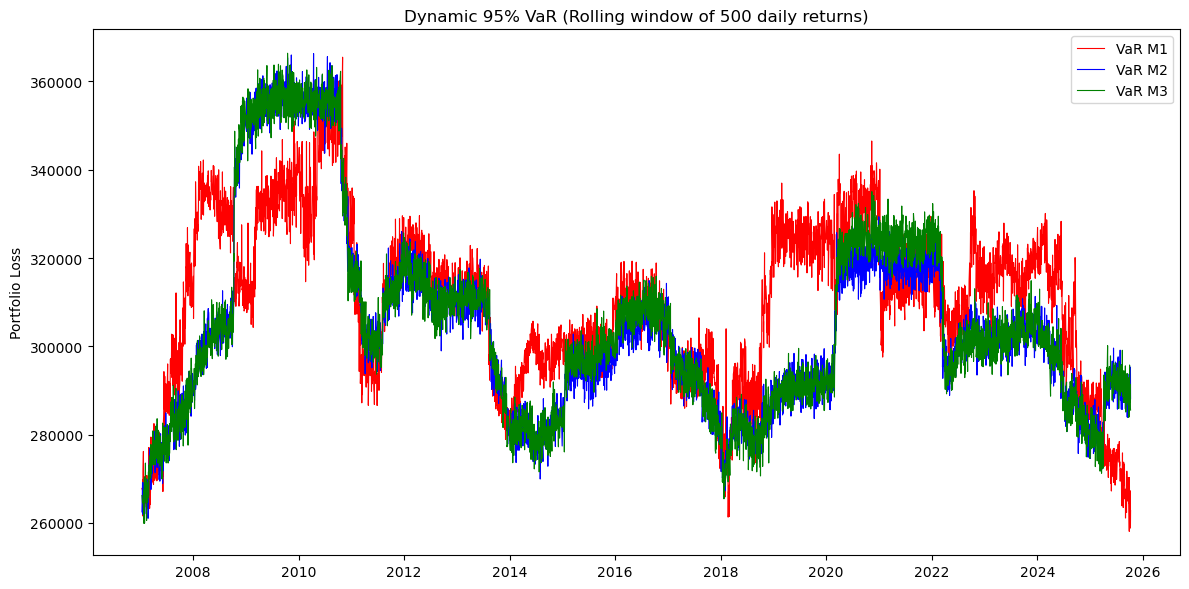

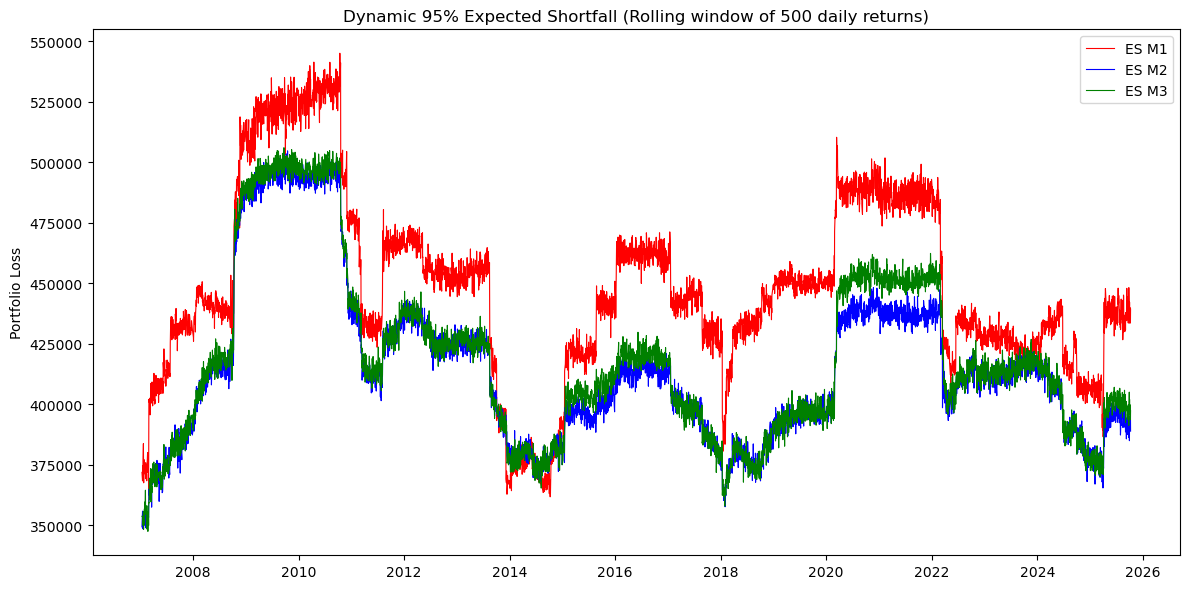

In [ ]:
# PLOT DYNAMIC VaR
plt.figure(figsize=(12, 6))
plt.plot(dates_series, VaR_M1_series, label="VaR M1", lw=0.8, color="red")
plt.plot(dates_series, VaR_M2_series, label="VaR M2", lw=0.8, color="blue")
plt.plot(dates_series, VaR_M3_series, label="VaR M3", lw=0.8, color="green")
plt.title("Dynamic 95% VaR (Rolling window of 500 da
ily returns)")
plt.ylabel("Portfolio Loss")
plt.legend()
plt.tight_layout()
plt.show()

# PLOT DYNAMIC ES
plt.figure(figsize=(12, 6))
plt.plot(dates_series, ES_M1_series, label="ES M1", lw=0.8, color="red")
plt.plot(dates_series, ES_M2_series, label="ES M2", lw=0.8, color="blue")
plt.plot(dates_series, ES_M3_series, label="ES M3", lw=0.8, color="green")
plt.title("Dynamic 95% Expected Shortfall (Rolling window of 500 daily returns)")
plt.ylabel("Portfolio Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
Dispersione_M1 = np.quantile(VaR_M1, [0.05, 0.5, 0.95])

print(Dispersione_M1)

[555120.47300609 555120.47300609 555120.47300609]


In [39]:
ratio_M1 = np.array(ES_M1_series) / np.array(VaR_M1_series)
ratio_M2 = np.array(ES_M2_series) / np.array(VaR_M2_series)
ratio_M3 = np.array(ES_M3_series) / np.array(VaR_M3_series)

print(ratio_M1)
print(ratio_M2)
print(ratio_M3)

[1.42473061 1.39604377 1.38357521 ... 1.60883402 1.65015164 1.63943135]
[1.36776643 1.32691341 1.3439994  ... 1.34658641 1.33738244 1.35474725]
[1.34123472 1.32848033 1.3274203  ... 1.36856234 1.39839147 1.40088474]


In [ ]:
# Defining new M3 model by t-copula and t-marginals 

def fit_student_t_marginal(x): # Fit MLE parameters of a univariate Student distribution 

    def neg_loglik(params):
        nu = params[0]
        mu = params[1]
        sigma = params[2]

        # Ensure valid variance and finite moments
        if sigma <= 0 or nu <= 2:
            return 1e12

        ll = stats.t.logpdf(x, df=nu, loc=mu, scale=sigma)
        return -np.sum(ll)

    # Starting values
    nu0 = 5
    mu0 = np.mean(x)
    sigma0 = np.std(x, ddof=0)
    x0 = np.array([nu0, mu0, sigma0])

    # Bounds: df in [2.1, 40], sigma > 0
    bounds = [(2.1, 40), (None, None), (1e-6, None)]

    res = minimize(neg_loglik, x0, method="L-BFGS-B", bounds=bounds)
    nu_hat, mu_hat, sigma_hat = res.x
    return nu_hat, mu_hat, sigma_hat


def fit_t_copula(U): # Fit a bivariate t-copula via MLE (returns rho and nu_copula).

    eps = 1e-12
    U = np.clip(U, eps, 1 - eps)
    u1 = U[:, 0]
    u2 = U[:, 1]

    def neg_loglik(params):
        a, b = params

        # Map a to rho in (-0.999, 0.999)
        rho = np.tanh(a)
        rho = np.clip(rho, -0.999, 0.999)

        # Map b to df in [2.1, 40]
        nu = 2.1 + np.exp(b)
        nu = np.clip(nu, 2.1, 40)

        # t-quantiles
        x1 = stats.t.ppf(u1, df=nu)
        x2 = stats.t.ppf(u2, df=nu)

        # Univariate t densities
        ft1_x1 = stats.t.pdf(x1, df=nu)
        ft1_x2 = stats.t.pdf(x2, df=nu)
        ft1_x1 = np.clip(ft1_x1, 1e-12, None)
        ft1_x2 = np.clip(ft1_x2, 1e-12, None)

        # Bivariate t density
        rho2 = rho * rho
        denom = nu * (1 - rho2)
        denom = np.clip(denom, 1e-10, None)

        quad = (x1**2 - 2 * rho * x1 * x2 + x2**2) / denom
        quad = np.clip(quad, -1e6, 1e6)

        log_ft2 = (
            gammaln((nu + 2) / 2)
            - gammaln(nu / 2)
            - np.log(np.pi * nu * np.sqrt(1 - rho2))
            - (nu + 2) / 2 * np.log1p(quad)
        )

        # Sum of marginal log-densities
        log_ft1 = np.log(ft1_x1) + np.log(ft1_x2)

        # Copula log-density = joint log-density - marginal log-densities
        log_c = log_ft2 - log_ft1

        if not np.all(np.isfinite(log_c)):
            return 1e12

        return -np.sum(log_c)

    # Starting values from Gaussian copula
    z_init = stats.norm.ppf(U)
    rho0 = np.corrcoef(z_init.T)[0, 1]
    a0 = np.arctanh(np.clip(rho0, -0.8, 0.8))
    b0 = np.log(5)
    x0 = np.array([a0, b0])

    res = minimize(
        neg_loglik,
        x0,
        method="L-BFGS-B",
        bounds=[(-5, 5), (np.log(0.1), np.log(50))]
    )

    a_hat, b_hat = res.x
    rho_hat = np.tanh(a_hat)
    rho_hat = np.clip(rho_hat, -0.999, 0.999)

    nu_copula = 2.1 + np.exp(b_hat)
    nu_copula = np.clip(nu_copula, 2.1, 40)

    return rho_hat, nu_copula, res


def fit_M3_t(Theta): #Fit the full M3-t model
    
    SPI = Theta[:, 0]
    SPX = Theta[:, 1]

    # t-marginals for SPI and SPX
    nu1, mu1, sigma1 = fit_student_t_marginal(SPI)
    nu2, mu2, sigma2 = fit_student_t_marginal(SPX)

    # Transform to uniforms via t-CDF
    U1 = stats.t.cdf(SPI, df=nu1, loc=mu1, scale=sigma1)
    U2 = stats.t.cdf(SPX, df=nu2, loc=mu2, scale=sigma2)
    U = np.column_stack([U1, U2])

    # Fit t-copula on U
    rho_copula, nu_copula, res_copula = fit_t_copula(U)

    return {
        "marginals": {
            "nu": np.array([nu1, nu2]),
            "mu": np.array([mu1, mu2]),
            "sigma": np.array([sigma1, sigma2]),
        },
        "copula": {
            "rho": rho_copula,
            "nu": nu_copula,
            "optimizer": res_copula,
        },
    }


def sim_M3_t(N, params, random_state=None): # Simulate N observations from the M3-t model:
    
    rng = np.random.default_rng(random_state)

    # Extract marginal and copula parameters
    nu1, nu2 = params["marginals"]["nu"]
    mu1, mu2 = params["marginals"]["mu"]
    sigma1, sigma2 = params["marginals"]["sigma"]
    rho = params["copula"]["rho"]
    nu_c = params["copula"]["nu"]

    # Simulate t-copula
    Sigma = np.array([[1.0, rho], [rho, 1.0]])
    A = np.linalg.cholesky(Sigma)

    Z = rng.standard_normal(size=(N, 2)) @ A.T
    W = rng.chisquare(df=nu_c, size=N)
    X = np.sqrt(nu_c / W)[:, None] * Z
    U = stats.t.cdf(X, df=nu_c)

    # Apply t-marginals
    SPI_sim = stats.t.ppf(U[:, 0], df=nu1, loc=mu1, scale=sigma1)
    SPX_sim = stats.t.ppf(U[:, 1], df=nu2, loc=mu2, scale=sigma2)

    return np.column_stack([SPI_sim, SPX_sim])

In [91]:
# Static 99% VaR/ES for model M3-t 

alpha = 0.99
N_sim = 10_000
In_random_state = 1   # seed

# Weekly log-returns Θ = (Δlog SPI, Δlog SPX)
weekly = (
    indexes.sort_values("date")
           .set_index("date")[["SPI", "SPX"]]
           .resample("W").last()
           .pct_change()
           .dropna()
)
Theta_weekly = np.log(1 + weekly).values   # shape (T, 2)

# Fit M3-t: t-marginals + t-copula
params_M3t = fit_M3_t(Theta_weekly)

# Simulate Θ under M3-t (using fixed seed)
Theta_M3t = sim_M3_t(N_sim, params_M3t, random_state=In_random_state)

# Latent variables Y = AΘ·√λ + ε·√(1−λ)·s
rng  = np.random.default_rng(In_random_state)
sys  = (Theta_M3t @ A.T) * np.sqrt(lambda_k)
idio = rng.standard_normal(size=(N_sim, K)) * (np.sqrt(1 - lambda_k) * s_k)
Y    = sys + idio

# Default thresholds d_k = Quantile_{π_k}(Y_k)
d_k = np.array([np.quantile(Y[:, k], pi_k[k]) for k in range(K)])

# Losses L_M3t = Σ_k LGD_k · 1{Y_k ≤ d_k}
I     = (Y <= d_k).astype(int)
L_M3t = (I * LGD).sum(axis=1)

In [ ]:
#   Extract parameters of M3-t

# Fit the model
params_M3t = fit_M3_t(Theta)

# Marginal parameters 
nu_marg = params_M3t["marginals"]["nu"]
mu_marg = params_M3t["marginals"]["mu"]
sigma_marg = params_M3t["marginals"]["sigma"]

# Copula parameters
rho_cop = params_M3t["copula"]["rho"]
nu_cop = params_M3t["copula"]["nu"]

print("=== M3-t parameters ===")
print("Marginal means μ:", mu_marg)
print("Marginal std deviations σ:", sigma_marg)
print("Marginal degrees of freedom ν_marg:", nu_marg)
print("Copula correlation ρ:", rho_cop)
print("Copula degrees of freedom ν_cop:", nu_cop)

#   Compute implied covariance + correlation

# Covariance matrix using marginal scales and copula correlation
Sigma_M3t = np.array([
    [sigma_marg[0]**2, rho_cop * sigma_marg[0] * sigma_marg[1]],
    [rho_cop * sigma_marg[0] * sigma_marg[1], sigma_marg[1]**2]
])

# Correlation 
corr_M3t = np.corrcoef(Sigma_M3t)[0, 1]

print("\nCovariance matrix Σ_M3t:")
print(Sigma_M3t)

print("\nCorrelation from covariance:", rho_cop)

=== M3-t parameters ===
Marginal means μ: [0.00311532 0.00344895]
Marginal std deviations σ: [0.01481929 0.01544376]
Marginal degrees of freedom ν_marg: [3.60731508 3.11506114]
Copula correlation ρ: 0.7079119718708201
Copula degrees of freedom ν_cop: 3.4968413813875263

Covariance matrix Σ_M3t:
[[0.00021961 0.00016202]
 [0.00016202 0.00023851]]

Correlation from covariance: 0.7079119718708201


In [77]:
# Computing again VaR & ES
def compute_var_es(L, alpha=0.99):
    VaR = np.quantile(L, alpha)
    ES  = L[L >= VaR].mean()
    return VaR, ES

alpha = 0.99

# For all the 4 models
VaR_M1, ES_M1 = compute_var_es(L_M1, alpha)
VaR_M2, ES_M2 = compute_var_es(L_M2, alpha)
VaR_M3, ES_M3 = compute_var_es(L_M3, alpha)
VaR_M3t, ES_M3t = compute_var_es(L_M3t, alpha)

# Results
print(f"=== STATIC PORTFOLIO RISK — {alpha*100:.0f}% VaR & ES ===\n")

print(f"M1 (Empirical Θ):      VaR = {VaR_M1:,.2f}   ES = {ES_M1:,.2f}")
print(f"M2 (Gaussian Θ):       VaR = {VaR_M2:,.2f}   ES = {ES_M2:,.2f}")
print(f"M3 (t-copula Θ):       VaR = {VaR_M3:,.2f}   ES = {ES_M3:,.2f}")
print(f"M3-t (t-margins+copula): VaR = {VaR_M3t:,.2f}   ES = {ES_M3t:,.2f}")

=== STATIC PORTFOLIO RISK — 99% VaR & ES ===

M1 (Empirical Θ):      VaR = 548,270.72   ES = 742,421.57
M2 (Gaussian Θ):       VaR = 486,743.38   ES = 590,656.53
M3 (t-copula Θ):       VaR = 498,010.62   ES = 612,306.10
M3-t (t-margins+copula): VaR = 520,489.24   ES = 712,482.95


In [ ]:
# Dynamic VaR & ES with rolling window of 500 daily returns


window = 500          # rolling window length (daily)
alpha = 0.95          # confidence level for VaR/ES
N_sim = 10000         # number of Monte Carlo simulations per window

# Build daily log-returns from prices (SPI/SPX) if not already present
if "r_SPI" not in indexes.columns or "r_SPX" not in indexes.columns:
    indexes = indexes.sort_values("date")
    indexes["r_SPI"] = np.log(indexes["SPI"] / indexes["SPI"].shift(1))
    indexes["r_SPX"] = np.log(indexes["SPX"] / indexes["SPX"].shift(1))

# Drop initial NaNs
indexes = (
    indexes
    .dropna(subset=["r_SPI", "r_SPX", "SPI", "SPX"])
    .reset_index(drop=True)
)

# Daily dataframe with dates, prices and returns
r_daily = indexes[["date", "SPI", "SPX", "r_SPI", "r_SPX"]].copy()
T_daily = len(r_daily)


def process_window(t):
    """
    Process window [t-window, t) and return VaR/ES for M1, M2, M3-t plus date.
    """
    # 1. Extract rolling daily window [t-window, t)
    window_data = r_daily.iloc[t - window:t].copy()
    wd = window_data.set_index("date")

    # 2. Build weekly log-returns from prices
    weekly_prices = wd[["SPI", "SPX"]].resample("W").last()

    weekly_tmp = pd.DataFrame(index=weekly_prices.index)
    weekly_tmp["rw_SPI"] = np.log(weekly_prices["SPI"] / weekly_prices["SPI"].shift(1))
    weekly_tmp["rw_SPX"] = np.log(weekly_prices["SPX"] / weekly_prices["SPX"].shift(1))
    weekly_tmp = weekly_tmp.dropna()

    Theta_weekly = weekly_tmp[["rw_SPI", "rw_SPX"]].values

    # Too few weekly returns → M3-t becomes unstable
    if Theta_weekly.shape[0] < 20:
        return (
            np.nan, np.nan, np.nan,
            np.nan, np.nan, np.nan,
            r_daily["date"].iloc[t]
        )

    # 3. Estimate M2 and M3-t on weekly data
    # M2: bivariate Gaussian
    mu_M2_t, Sigma_M2_t = fit_M2(Theta_weekly)

    # M3-t: t-margins + t-copula
    params_M3t_t = fit_M3_t(Theta_weekly)

    # 4. Simulate Θ under M1, M2, M3-t
    # M1: empirical distribution within the window
    T_w = Theta_weekly.shape[0]
    idx = np.random.randint(0, T_w, size=N_sim)
    Theta_M1_t = Theta_weekly[idx, :]

    # M2: bivariate Gaussian on the window
    Theta_M2_t = sim_M2(N_sim, mu_M2_t, Sigma_M2_t)

    # M3-t: t-copula + t-margins on the window
    Theta_M3_t = sim_M3_t(N_sim, params_M3t_t)

    # 5. Construct latent variables Y_k
    sys_M1_t = (Theta_M1_t @ A.T) * np.sqrt(lambda_k)[None, :]
    sys_M2_t = (Theta_M2_t @ A.T) * np.sqrt(lambda_k)[None, :]
    sys_M3_t = (Theta_M3_t @ A.T) * np.sqrt(lambda_k)[None, :]

    eps_t = np.random.randn(N_sim, K)
    idio_t = np.sqrt(1 - lambda_k)[None, :] * s_k[None, :] * eps_t

    Y_M1_t = sys_M1_t + idio_t
    Y_M2_t = sys_M2_t + idio_t
    Y_M3_t = sys_M3_t + idio_t

    # 6. Dynamic calibration of d_k for M1, M2, M3-t (P(Y_k ≤ d_k) = pi_k)
    d_k_M1_t = np.zeros(K)
    d_k_M2_t = np.zeros(K)
    d_k_M3_t = np.zeros(K)

    for k in range(K):
        d_k_M1_t[k] = np.quantile(Y_M1_t[:, k], pi_k[k])
        d_k_M2_t[k] = np.quantile(Y_M2_t[:, k], pi_k[k])
        d_k_M3_t[k] = np.quantile(Y_M3_t[:, k], pi_k[k])

    # 7. Portfolio losses for each model
    I_M1_t = (Y_M1_t <= d_k_M1_t[None, :]).astype(int)
    I_M2_t = (Y_M2_t <= d_k_M2_t[None, :]).astype(int)
    I_M3_t = (Y_M3_t <= d_k_M3_t[None, :]).astype(int)

    L_M1_t = (I_M1_t * LGD[None, :]).sum(axis=1)
    L_M2_t = (I_M2_t * LGD[None, :]).sum(axis=1)
    L_M3_t = (I_M3_t * LGD[None, :]).sum(axis=1)

    # 8. Compute VaR and ES from simulated losses
    def compute_var_es(L):
        VaR = np.quantile(L, alpha)
        ES = L[L >= VaR].mean()
        return VaR, ES

    VaR_M1_t, ES_M1_t = compute_var_es(L_M1_t)
    VaR_M2_t, ES_M2_t = compute_var_es(L_M2_t)
    VaR_M3_t, ES_M3_t = compute_var_es(L_M3_t)

    return (
        VaR_M1_t, VaR_M2_t, VaR_M3_t,
        ES_M1_t, ES_M2_t, ES_M3_t,
        r_daily["date"].iloc[t]
    )


print("Starting parallel rolling VaR/ES...\n")

results = Parallel(n_jobs=-3)(
    delayed(process_window)(t)
    for t in tqdm(range(window, T_daily), desc="Rolling windows")
)

print("\nParallel rolling VaR/ES completed.")

# Rebuild final time series
VaR_M1_series = []
VaR_M2_series = []
VaR_M3_series = []

ES_M1_series = []
ES_M2_series = []
ES_M3_series = []

dates_series = []

for res in results:
    v1, v2, v3, e1, e2, e3, date = res
    VaR_M1_series.append(v1) 
    VaR_M2_series.append(v2)
    VaR_M3_series.append(v3)
    ES_M1_series.append(e1)
    ES_M2_series.append(e2)
    ES_M3_series.append(e3)
    dates_series.append(date)

Starting parallel rolling VaR/ES...



/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Rolling windows: 100%|██████████| 4591/4591 [02:04<00:00, 37.01it/s]



Parallel rolling VaR/ES completed.


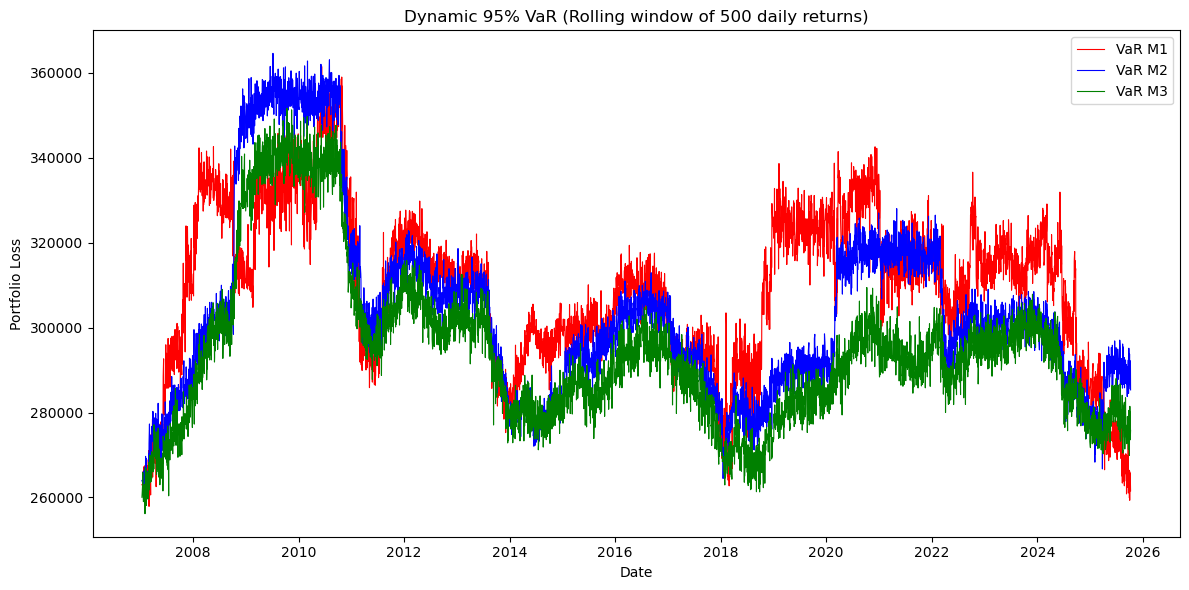

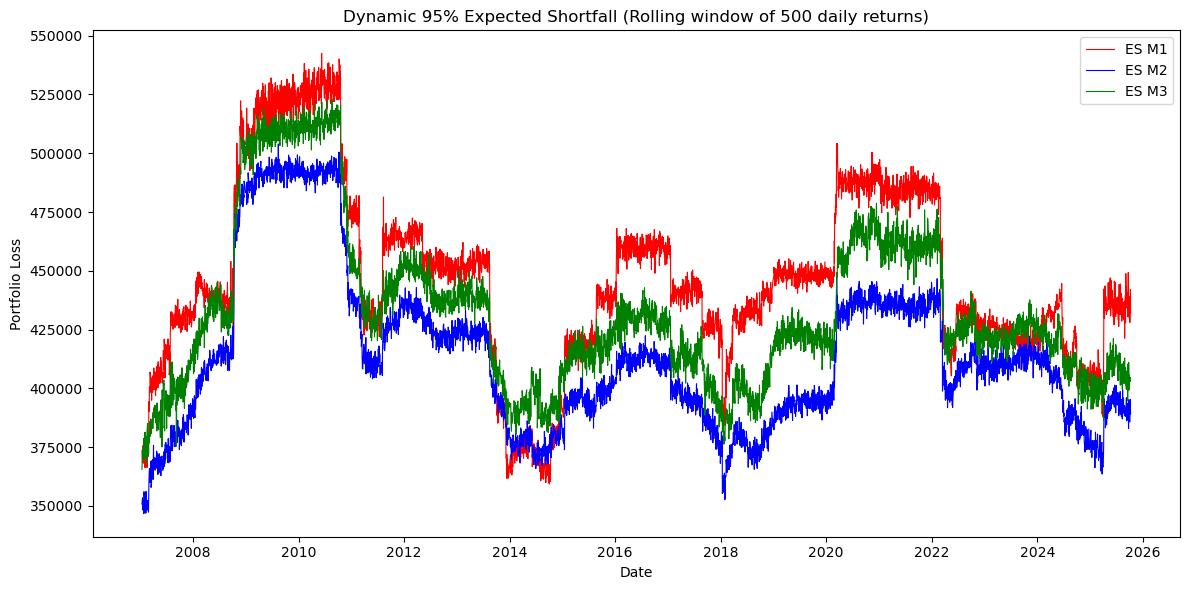

In [ ]:
# PLOT DYNAMIC VaR
plt.figure(figsize=(12, 6))
plt.plot(dates_series, VaR_M1_series, label="VaR M1", lw=0.8, color="red")
plt.plot(dates_series, VaR_M2_series, label="VaR M2", lw=0.8, color="blue")
plt.plot(dates_series, VaR_M3_series, label="VaR M3", lw=0.8, color="green")
plt.title("Dynamic 95% VaR (Rolling window of 500 daily returns)")
plt.xlabel("Date")
plt.ylabel("Portfolio Loss")
plt.legend()
plt.tight_layout()
plt.show()

# PLOT DYNAMIC ES
plt.figure(figsize=(12, 6))
plt.plot(dates_series, ES_M1_series, label="ES M1", lw=0.8, color="red")
plt.plot(dates_series, ES_M2_series, label="ES M2", lw=0.8, color="blue")
plt.plot(dates_series, ES_M3_series, label="ES M3", lw=0.8, color="green")
plt.title("Dynamic 95% Expected Shortfall (Rolling window of 500 daily returns)")
plt.xlabel("Date")
plt.ylabel("Portfolio Loss")
plt.legend()
plt.tight_layout()
plt.show()